In [1]:
from matplotlib import pylab as plt
from skimage import io

%matplotlib inline

In [5]:
IMG_NAME = '00023.jpg'
img = io.imread('./images/' + IMG_NAME)
img_mir = io.imread('./images_mirrored/' + IMG_NAME)

mir_pts = [1601,552,1073,448,768,430,489,440,1433,585,1276,567,1149,567,798,526,674,491,577,496,732,1004,1192,1252,819,1258,649,1164]
mir_xs = mir_pts[0::2]
mir_ys = mir_pts[1::2]

pts = [272,552,800,448,1105,430,1384,440,440,585,597,567,724,567,1075,526,1199,491,1296,496,1141,1004,681,1252,1054,1258,1224,1164]
xs = pts[0::2]
ys = pts[1::2]

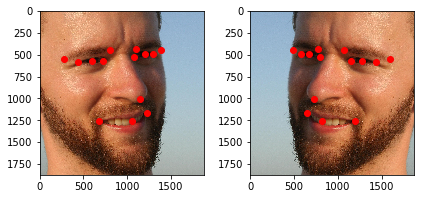

In [12]:
plt.figure(1)

plt.subplot(121)
io.imshow(img)
plt.plot(xs, ys, 'ro')

plt.subplot(122)
io.imshow(img_mir)
plt.plot(mir_xs, mir_ys, 'ro')

In [14]:
from pickle import load

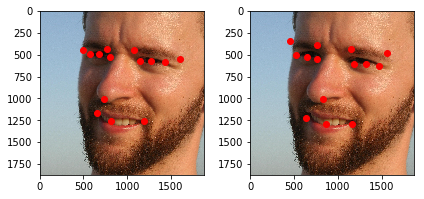

In [24]:
plt.figure(1)

plt.subplot(121)
io.imshow(img_mir)
plt.plot(mir_xs, mir_ys, 'ro')

with open('detected.pickle', 'rb') as f:
    predicted = load(f)[IMG_NAME]
pred_xs = predicted[0::2]
pred_ys = predicted[1::2]
plt.subplot(122)
io.imshow(img_mir)
plt.plot(pred_xs, pred_ys, 'ro')

In [36]:
mir = np.sort(np.array(mir_pts))
pred = np.sort(predicted.copy())

In [8]:
import pandas as pd
import numpy as np

In [39]:
gt = pd.read_csv('gt.csv')
gt_mir = pd.read_csv('gt_rev.csv')

In [119]:
IMAGE_SIZE = (100, 100, 3)
SAMPLES_COUNT = 12000
YS_PER_SAMPLE = 28
POINTS_PER_SAMPLE = YS_PER_SAMPLE // 2

In [59]:
X = np.ndarray(shape=(SAMPLES_COUNT,) + IMAGE_SIZE)
y = np.ndarray(shape=(SAMPLES_COUNT, YS_PER_SAMPLE))
scales = np.ndarray(shape=(SAMPLES_COUNT, 2))

In [58]:
for x, m in gt.groupby(['filename']):
    print(m.as_matrix())
    break

[['00000.jpg' 51 51 127 60 169 65 203 52 68 77 85 75 110 82 160 87 171 79
  193 84 156 144 92 174 140 180 168 179]]


In [70]:
def append_samples_from(images_dir, target_shape, gt, X, y, scales, size):
    from os import listdir
    from skimage import io
    from skimage.transform import resize

    i = size
    for filename in listdir(images_dir):
        image = io.imread(images_dir + filename)
        image_h, image_w = image.shape[0:2]
        new_h, new_w = target_shape[0:2]
        X[i, :, :, :] = resize(image, target_shape, mode='reflect').astype(np.float64)
        y[i, :] = gt[gt.filename == filename].as_matrix()[0, 1:]
        scales[i, :] = np.array([image_w / new_w, image_h / new_h])
        i += 1
    return i

In [71]:
written_size = append_samples_from('./images/', IMAGE_SIZE, gt, X, y, scales, 0)
print(written_size)
written_size = append_samples_from('./images_mirrored/', IMAGE_SIZE, gt_mir, X, y, scales, written_size)
print(written_size)

6000
12000


In [81]:
from pickle import dump

for obj, filename in zip([X, y, scales], ['X', 'y', 'scales']):
    with open(filename + '.pickle', 'wb') as f:
        dump(obj, f)

In [122]:
from random import sample

X_test = np.ndarray(shape=(3000,) + IMAGE_SIZE)
y_test = np.ndarray(shape=(3000, YS_PER_SAMPLE))
scales_test = np.ndarray(shape=(3000, 2))

X_train = np.ndarray(shape=(9000,) + IMAGE_SIZE)
y_train = np.ndarray(shape=(9000, YS_PER_SAMPLE))
scales_train = np.ndarray(shape=(9000, 2))

train_indices = np.ones(12000, dtype=bool)

# from the initial set of pictures
np.random.seed(1)
test_indices = np.array(sample(range(0, 6000), 1500))
X_test[:1500, :] = X[test_indices, :]
scales_test[:1500, :] = scales[test_indices, :]
y_test[:1500, :] =\
    y[test_indices, :] * np.tile(1 / scales_test[:1500, :], POINTS_PER_SAMPLE)
train_indices[test_indices] = False

# from the set of mirrored pictures
np.random.seed(2)
test_indices = np.array(sample(range(6000, 12000), 1500))
X_test[1500:, :] = X[test_indices, :]
scales_test[1500:, :] = scales[test_indices, :]
y_test[1500:, :] =\
    y[test_indices, :] * np.tile(1 / scales_test[1500:, :], POINTS_PER_SAMPLE)
train_indices[test_indices] = False

# prepare the train set
X_train[:] = X[train_indices]
scales_train[:] = scales[train_indices]
y_train[:] = y[train_indices] * np.tile(1 / scales_train, POINTS_PER_SAMPLE)

In [123]:
from pickle import dump

for obj, filename in zip([X_test, y_test, scales_test], ['X', 'y', 'scales']):
    with open('./split/' + filename + '_test.pickle', 'wb') as f:
        dump(obj, f)
for obj, filename in zip([X_train, y_train, scales_train], ['X', 'y', 'scales']):
    with open('./split/' + filename + '_train.pickle', 'wb') as f:
        dump(obj, f)